In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
# Importing data and viewing first 5 rows
df = pd.read_csv('data/syriatelcustomerchurn.csv')
df.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

# Exploratory Data Analysis & Data Cleaning

In [3]:
# Looking at the shape tells us the dataset contains 3333 rows and 21 columns
df.shape

(3333, 21)

In [4]:
# Checking the datatypes of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [5]:
# Replacing spaces with underscores in column titles

df.columns = df.columns.str.replace(" ", "_")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [6]:
# Checking for null values; we can see there are none
df.isna().sum()
print ("This dataset contains %d null values." % df.isna().sum().sum())

This dataset contains 0 null values.


In [7]:
# Dropping 'phone_number' column as it is a unique identifier irrelevant to this analysis

df = df.drop(columns = 'phone_number', axis=1)
df.shape

(3333, 20)

In [8]:
df.churn

0       False
1       False
2       False
3       False
4       False
        ...  
3328    False
3329    False
3330    False
3331    False
3332    False
Name: churn, Length: 3333, dtype: bool

In [9]:
df.churn.value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [10]:
# Investigate sample statistics of numeric data
df.describe()

account_length    area_code  number_vmail_messages  total_day_minutes  \
count     3333.000000  3333.000000            3333.000000        3333.000000   
mean       101.064806   437.182418               8.099010         179.775098   
std         39.822106    42.371290              13.688365          54.467389   
min          1.000000   408.000000               0.000000           0.000000   
25%         74.000000   408.000000               0.000000         143.700000   
50%        101.000000   415.000000               0.000000         179.400000   
75%        127.000000   510.000000              20.000000         216.400000   
max        243.000000   510.000000              51.000000         350.800000   

       total_day_calls  total_day_charge  total_eve_minutes  total_eve_calls  \
count      3333.000000       3333.000000        3333.000000      3333.000000   
mean        100.435644         30.562307         200.980348       100.114311   
std          20.069084          9.259435          50.713844        19.922625   
min           0.000000          0.000000           0.000000         0.000000   
25%          87.000000         24.430000         166.600000        87.000000   
50%         101.000000         30.500000         201.400000       100.000000   
75%         114.000000         36.790000         235.300000       114.000000   
max         165.000000         59.640000         363.700000       170.000000   

       total_eve_charge  total_night_minutes  total_night_calls  \
count       3333.000000          3333.000000        3333.000000   
mean          17.083540           200.872037         100.107711   
std            4.310668            50.573847          19.568609   
min            0.000000            23.200000          33.000000   
25%           14.160000           167.000000          87.000000   
50%           17.120000           201.200000         100.000000   
75%           20.000000           235.300000         113.000000   
max           30.910000           395.000000         175.000000   

       total_night_charge  total_intl_minutes  total_intl_calls  \
count         3333.000000         3333.000000       3333.000000   
mean             9.039325           10.237294          4.479448   
std              2.275873            2.791840          2.461214   
min              1.040000            0.000000          0.000000   
25%              7.520000            8.500000          3.000000   
50%              9.050000           10.300000          4.000000   
75%             10.590000           12.100000          6.000000   
max             17.770000           20.000000         20.000000   

       total_intl_charge  customer_service_calls  
count        3333.000000             3333.000000  
mean            2.764581                1.562856  
std             0.753773                1.315491  
min             0.000000                0.000000  
25%             2.300000                1.000000  
50%             2.780000                1.000000  
75%             3.270000                2.000000  
max             5.400000                9.000000

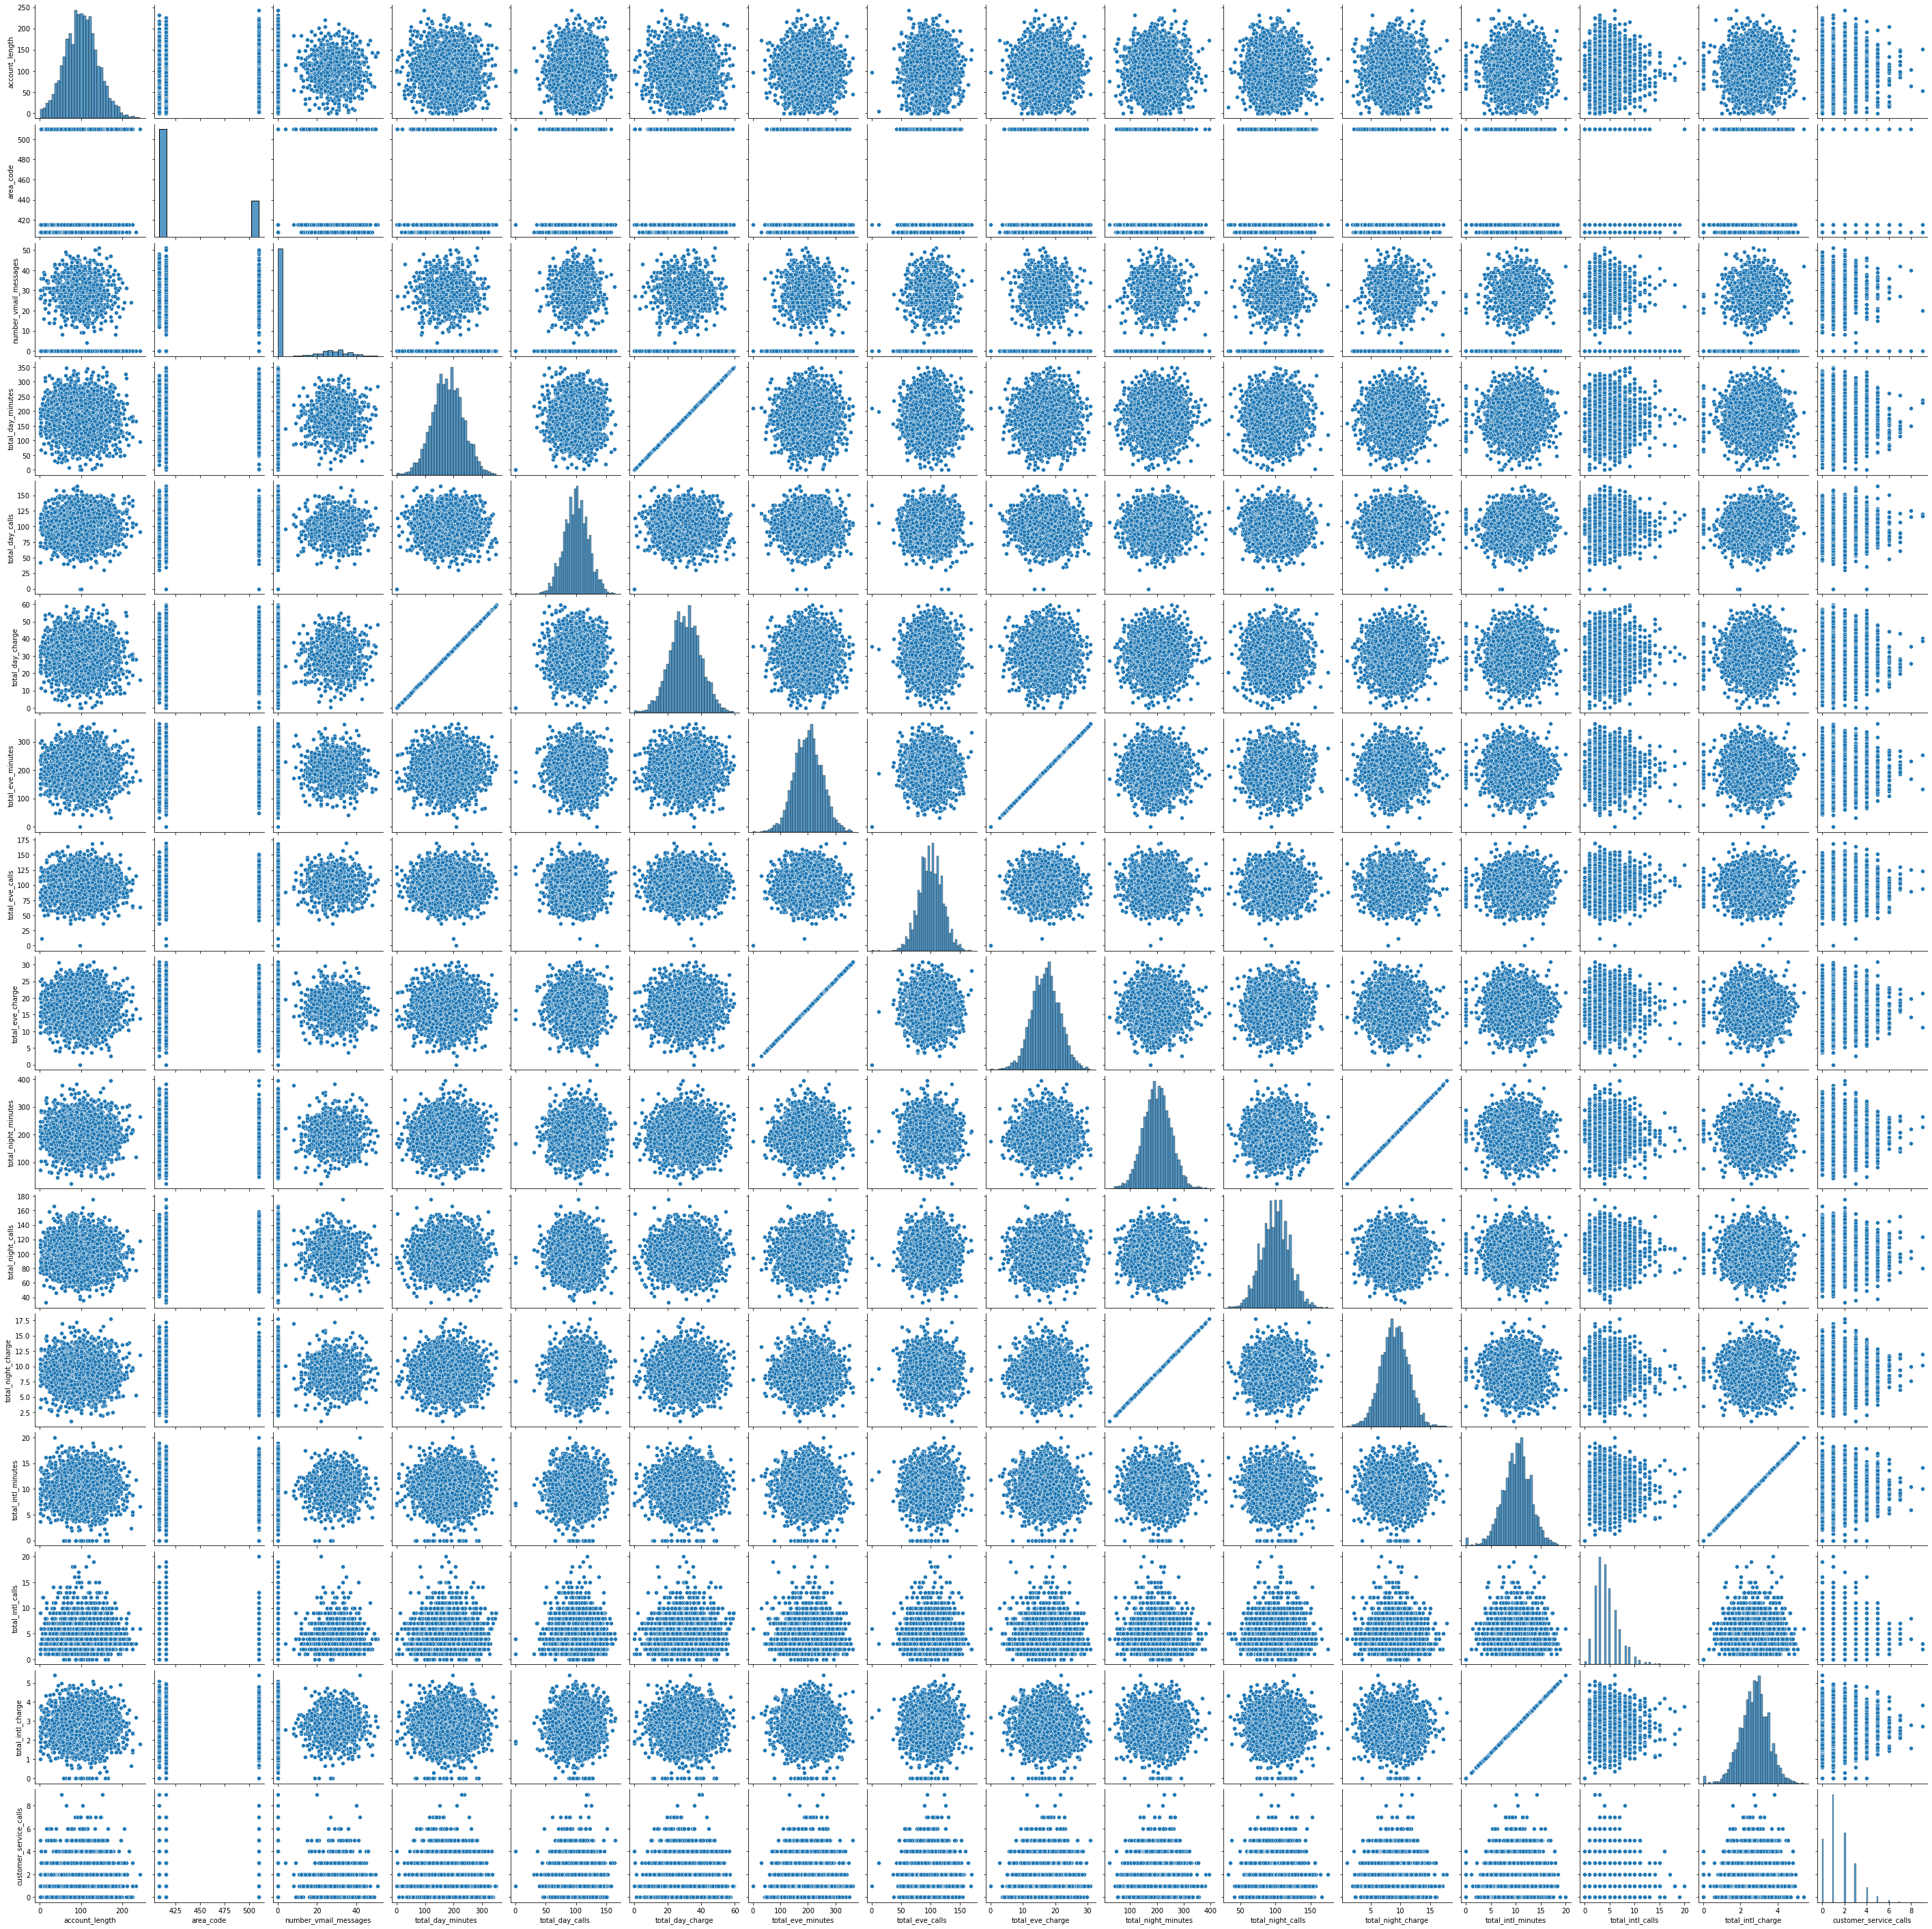

In [11]:
# Visualziing distribution of numeric data with pairplot
numeric_columns = df.select_dtypes(include = np.number)
sns.pairplot(numeric_columns)

Analyzing the pairplot of the numerical columns shows us the data is normally distributed, with the exception of 'area_code' which appears to be categorical, as well as 'number_vmail_messages' which has a strong outlier at zero. As we might expect, there is a strong positive linear relationship between 'total_day_minutes' and 'total_day_charge'; 'total_eve_minutes' and 'total_eve_charge"; 'total_night_minutes' and 'total_night_charge'; 'total_intl_calls' and 'total_intl_charge'.

In [12]:
# Transforming 'area_code' datatype from number to object
df.area_code = df.area_code.astype(object)

In [13]:
df.area_code

0       415
1       415
2       415
3       408
4       415
       ... 
3328    415
3329    415
3330    510
3331    510
3332    415
Name: area_code, Length: 3333, dtype: object

In [14]:
# Reassigning the 'numeric_columns' variable to exclude 'area_code'

numeric_columns = df.select_dtypes(include = np.number)
numeric_columns.head()

account_length  number_vmail_messages  total_day_minutes  total_day_calls  \
0             128                     25              265.1              110   
1             107                     26              161.6              123   
2             137                      0              243.4              114   
3              84                      0              299.4               71   
4              75                      0              166.7              113   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   total_night_minutes  total_night_calls  total_night_charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total_intl_minutes  total_intl_calls  total_intl_charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer_service_calls  
0                       1  
1                       1  
2                       0  
3                       2  
4                       3

In [15]:
# Assign variable for categorical data
categorical_columns = df.select_dtypes(exclude = np.number)
categorical_columns

state area_code international_plan voice_mail_plan  churn
0       KS       415                 no             yes  False
1       OH       415                 no             yes  False
2       NJ       415                 no              no  False
3       OH       408                yes              no  False
4       OK       415                yes              no  False
...    ...       ...                ...             ...    ...
3328    AZ       415                 no             yes  False
3329    WV       415                 no              no  False
3330    RI       510                 no              no  False
3331    CT       510                yes              no  False
3332    TN       415                 no             yes  False

[3333 rows x 5 columns]

In [16]:
#categorical_columns.international_plan = categorical_columns.international_plan.apply(lambda x: 0 if x=="no" else 1)

In [17]:
#categorical_columns.voice_mail_plan = categorical_columns.voice_mail_plan.apply(lambda x: 0 if x=="no" else 1)

In [18]:

categorical_columns.churn = categorical_columns.churn.apply(lambda x: 0 if x==False else 1)

C:\Users\19736\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
categorical_columns

state area_code international_plan voice_mail_plan  churn
0       KS       415                 no             yes      0
1       OH       415                 no             yes      0
2       NJ       415                 no              no      0
3       OH       408                yes              no      0
4       OK       415                yes              no      0
...    ...       ...                ...             ...    ...
3328    AZ       415                 no             yes      0
3329    WV       415                 no              no      0
3330    RI       510                 no              no      0
3331    CT       510                yes              no      0
3332    TN       415                 no             yes      0

[3333 rows x 5 columns]

In [52]:
categorical_columns.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [21]:
categorical_columns.voice_mail_plan

0       yes
1       yes
2        no
3        no
4        no
       ... 
3328    yes
3329     no
3330     no
3331     no
3332    yes
Name: voice_mail_plan, Length: 3333, dtype: object

In [91]:
# Plot 1 visualizes the question: 'For customers who had or did not have voicemail plans, how many churned vs. did not churn'
fig, ax = plt.subplots()

sns.countplot(x="voice_mail_plan", hue="churn", data=categorical_columns,
            palette={1:"red", 0:"blue"}, ax=ax)

ax.set_xlabel("Voicemail Plan")

color_patches = [
    Patch(facecolor="red", label="Churn"),
    Patch(facecolor="blue", label="No Churn")
]
ax.legend(handles=color_patches)

fig.suptitle("Voicemail Plan vs. Churn")
plt.savefig('vmp1.jpg')
plt.close()

#Plot 2 visualizes question from plot 1 but displays a proportion
vmp_counts_df = categorical_columns.groupby(["voice_mail_plan", "churn"])["churn"].count().unstack()
vmp_churn_percents_df = vmp_counts_df.T.div(vmp_counts_df.T.sum()).T
fig, ax = plt.subplots()

vmp_churn_percents_df.plot(kind="bar", stacked=True, color=["blue", "red"], ax=ax)

ax.set_xlabel("Voicemail Plan")
ax.set_xticklabels(['yes', 'no'], rotation=0)
ax.set_ylabel("Proportion")

color_patches = [
    Patch(facecolor="blue", label="No Churn"),
    Patch(facecolor="red", label="Churn")
]
ax.legend(handles=color_patches)

fig.suptitle("Voicemail Plan vs. Churn")
plt.savefig('vmp2.jpg')
plt.close()

# Plot 3 visualizes the question: 'For customers who churned vs. did not churn, how many had or did not have voicemail plans
fig, ax = plt.subplots()

sns.countplot(x="churn", hue="voice_mail_plan", data=categorical_columns,
            palette={'yes':"yellow", 'no':"orange",}, ax=ax)

ax.legend(title="Voicemail Plan")
ax.set_xticklabels(["No Churn", "Churn"])
ax.set_xlabel("")

fig.suptitle("Churn vs. Voicemail Plan");
plt.savefig('vmp3.jpg')
plt.close()

#Plot 4 visualizes question from plot 3 but displays a proportion
churn_vmp_percents_df = vmp_counts_df.div(vmp_counts_df.sum()).T
fig, ax = plt.subplots()

churn_vmp_percents_df.plot(kind="bar", stacked=True, color=["orange", "yellow"], ax=ax)

ax.legend(title="Voicemail Plan")
ax.set_xticklabels(["No Churn", "Churn"], rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Proportion")

fig.suptitle("Churn vs. Voicemail Plan")
plt.savefig('vmp4.jpg')
plt.close()

# Display all plots together by typing the following in markdown cell: **Voicemail Plan vs. Churn Count:** ![](vmp1.jpg)
#**Voicemail Plan vs. Churn Proportion:** ![](vmp2.jpg) **Churn vs. Voicemail Plan Count** ![](vmp3.jpg) 
#**Churn vs. Voicemail Plan Proportion:** ![](vmp4.jpg) 

**Voicemail Plan vs. Churn Count:** ![](vmp1.jpg)   **Voicemail Plan vs. Churn Proportion:** ![](vmp2.jpg) **Churn vs. Voicemail Plan Count** ![](vmp3.jpg)  **Churn vs. Voicemail Plan Proportion:** ![](vmp4.jpg)

In [92]:
# Plot 1 visualizes the question: 'For customers who had or did not have international plans, how many churned vs. did not churn'
fig, ax = plt.subplots()

sns.countplot(x="international_plan", hue="churn", data=categorical_columns,
            palette={1:"red", 0:"blue"}, ax=ax)

ax.set_xlabel("International Plan")

color_patches = [
    Patch(facecolor="red", label="Churn"),
    Patch(facecolor="blue", label="No Churn")
]
ax.legend(handles=color_patches)

fig.suptitle("International Plan vs. Churn");
plt.savefig('intlplan1.jpg')
plt.close()

#Plot 2 visualizes question from plot 1 but displays a proportion
intl_counts_df = categorical_columns.groupby(["international_plan", "churn"])["churn"].count().unstack()
intl_churn_percents_df = intl_counts_df.T.div(intl_counts_df.T.sum()).T
fig, ax = plt.subplots()

intl_churn_percents_df.plot(kind="bar", stacked=True, color=["blue", "red"], ax=ax)
ax.set_xlabel("International Plan")
ax.set_xticklabels(['yes', 'no'], rotation=0)
ax.set_ylabel("Proportion")

color_patches = [
    Patch(facecolor="blue", label="No Churn"),
    Patch(facecolor="red", label="Churn")
]
ax.legend(handles=color_patches)

fig.suptitle("International Plan vs. Churn")
plt.savefig('intlplan2.jpg')
plt.close()

# Plot 3 visualizes the question: 'For customers who churned vs. did not churn, how many had or did not have international plans
fig, ax = plt.subplots()

sns.countplot(x="churn", hue="international_plan", data=categorical_columns,
            palette={'yes':"yellow", 'no':"orange",}, ax=ax)

ax.legend(title="International Plan")
ax.set_xticklabels(["No Churn", "Churn"])
ax.set_xlabel("")

fig.suptitle("Churn vs. International Plan");
plt.savefig('intlplan3.jpg')
plt.close()

#Plot 4 visualizes question from plot 3 but displays a proportion
intl_churn_percents_df = intl_counts_df.div(intl_counts_df.sum()).T
fig, ax = plt.subplots()

intl_churn_percents_df.plot(kind="bar", stacked=True, color=["orange", "yellow"], ax=ax)

ax.legend(title="International Plan")
ax.set_xticklabels(["No Churn", "Churn"], rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Proportion")

fig.suptitle("Churn vs. International Plan")
plt.savefig('intlplan4.jpg')
plt.close()

# Display all plots together by typing the following in markdown cell: **International Plan vs. Churn Count:** ![](intlplan1.jpg)
#**International Plan vs. Churn Proportion:** ![](intlplan2.jpg) **Churn vs. International Plan Count** ![](intlplan3.jpg) 
#**Churn vs. Voicemail Plan Proportion:** ![](intlplan4.jpg) 

**International Plan vs. Churn Count:** ![](intlplan1.jpg)   **International Plan vs. Churn Proportion:** ![](intlplan2.jpg) **Churn vs. International Plan Count** ![](intlplan3.jpg)  **Churn vs. International Plan Proportion:** ![](intlplan4.jpg) 

In [23]:
categorical_columns.value_counts()

state  area_code  international_plan  voice_mail_plan  churn
WV     415        no                  no               0        36
NY     415        no                  no               0        27
MN     415        no                  no               0        25
AL     415        no                  no               0        25
OR     415        no                  no               0        25
                                                                ..
UT     510        no                  yes              1         1
MT     510        no                  yes              1         1
                  yes                 yes              0         1
ID     415        no                  yes              1         1
NV     510        yes                 no               1         1
Length: 691, dtype: int64

In [93]:
numeric_columns

account_length  number_vmail_messages  total_day_minutes  \
0                128                     25              265.1   
1                107                     26              161.6   
2                137                      0              243.4   
3                 84                      0              299.4   
4                 75                      0              166.7   
...              ...                    ...                ...   
3328             192                     36              156.2   
3329              68                      0              231.1   
3330              28                      0              180.8   
3331             184                      0              213.8   
3332              74                     25              234.4   

      total_day_calls  total_day_charge  total_eve_minutes  total_eve_calls  \
0                 110             45.07              197.4               99   
1                 123             27.47              195.5              103   
2                 114             41.38              121.2              110   
3                  71             50.90               61.9               88   
4                 113             28.34              148.3              122   
...               ...               ...                ...              ...   
3328               77             26.55              215.5              126   
3329               57             39.29              153.4               55   
3330              109             30.74              288.8               58   
3331              105             36.35              159.6               84   
3332              113             39.85              265.9               82   

      total_eve_charge  total_night_minutes  total_night_calls  \
0                16.78                244.7                 91   
1                16.62                254.4                103   
2                10.30                162.6                104   
3                 5.26                196.9                 89   
4                12.61                186.9                121   
...                ...                  ...                ...   
3328             18.32                279.1                 83   
3329             13.04                191.3                123   
3330             24.55                191.9                 91   
3331             13.57                139.2                137   
3332             22.60                241.4                 77   

      total_night_charge  total_intl_minutes  total_intl_calls  \
0                  11.01                10.0                 3   
1                  11.45                13.7                 3   
2                   7.32                12.2                 5   
3                   8.86                 6.6                 7   
4                   8.41                10.1                 3   
...                  ...                 ...               ...   
3328               12.56                 9.9                 6   
3329                8.61                 9.6                 4   
3330                8.64                14.1                 6   
3331                6.26                 5.0                10   
3332               10.86                13.7                 4   

      total_intl_charge  customer_service_calls  
0                  2.70                       1  
1                  3.70                       1  
2                  3.29                       0  
3                  1.78                       2  
4                  2.73                       3  
...                 ...                     ...  
3328               2.67                       2  
3329               2.59                       3  
3330               3.81                       2  
3331               1.35                       2  
3332               3.70                       0  

[3333 rows x 15 columns]

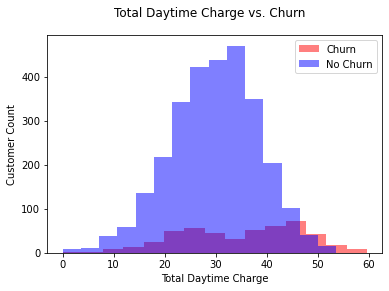

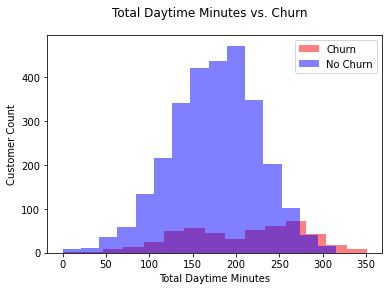

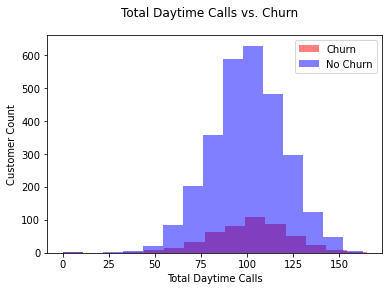

In [115]:
# Histograms for numeric daytime attributes vs. churn
fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["total_day_charge"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["total_day_charge"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Total Daytime Charge")
ax.set_ylabel("Customer Count")

fig.suptitle("Total Daytime Charge vs. Churn")

ax.legend();



fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["total_day_minutes"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["total_day_minutes"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Total Daytime Minutes")
ax.set_ylabel("Customer Count")

fig.suptitle("Total Daytime Minutes vs. Churn")

ax.legend();


fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["total_day_calls"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["total_day_calls"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Total Daytime Calls")
ax.set_ylabel("Customer Count")

fig.suptitle("Total Daytime Calls vs. Churn")

ax.legend();

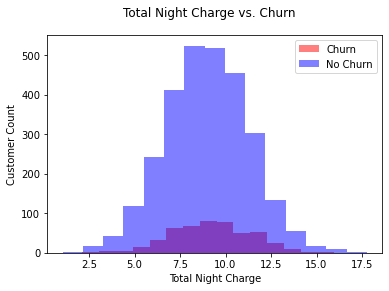

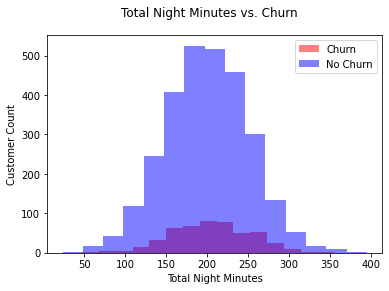

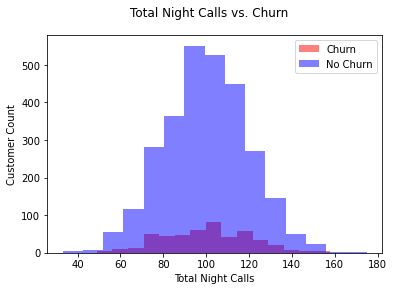

In [114]:
# Histograms for numeric night attributes vs. churn
fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["total_night_charge"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["total_night_charge"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Total Night Charge")
ax.set_ylabel("Customer Count")

fig.suptitle("Total Night Charge vs. Churn")

ax.legend();



fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["total_night_minutes"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["total_night_minutes"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Total Night Minutes")
ax.set_ylabel("Customer Count")

fig.suptitle("Total Night Minutes vs. Churn")

ax.legend();

fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["total_night_calls"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["total_night_calls"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Total Night Calls")
ax.set_ylabel("Customer Count")

fig.suptitle("Total Night Calls vs. Churn")

ax.legend();

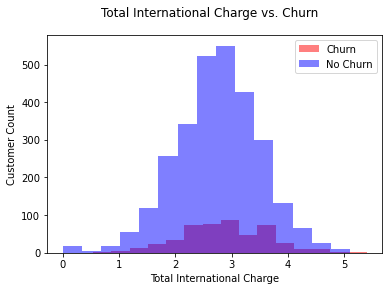

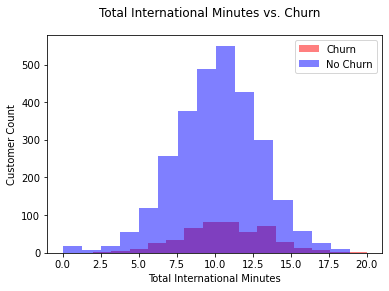

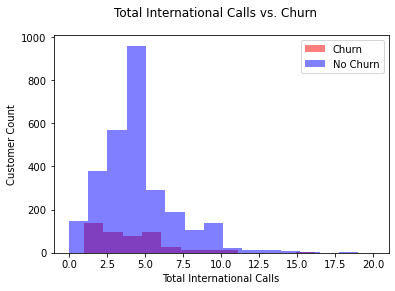

In [123]:
# Histograms for numeric international attributes vs. churn
fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["total_intl_charge"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["total_intl_charge"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Total International Charge")
ax.set_ylabel("Customer Count")

fig.suptitle("Total International Charge vs. Churn")

ax.legend();



fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["total_intl_minutes"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["total_intl_minutes"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Total International Minutes")
ax.set_ylabel("Customer Count")

fig.suptitle("Total International Minutes vs. Churn")

ax.legend();


fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["total_intl_calls"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["total_intl_calls"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Total International Calls")
ax.set_ylabel("Customer Count")

fig.suptitle("Total International Calls vs. Churn")

ax.legend();

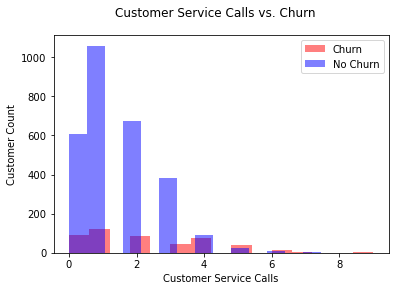

In [124]:
# Histogram for customer service calls vs. churn

fig, ax = plt.subplots()

ax.hist(df[df["churn"]==True]["customer_service_calls"], bins=15, alpha=0.5, color="red", label="Churn")
ax.hist(df[df["churn"]==False]["customer_service_calls"], bins=15, alpha=0.5, color="blue", label="No Churn")

ax.set_xlabel("Customer Service Calls")
ax.set_ylabel("Customer Count")

fig.suptitle("Customer Service Calls vs. Churn")

ax.legend();

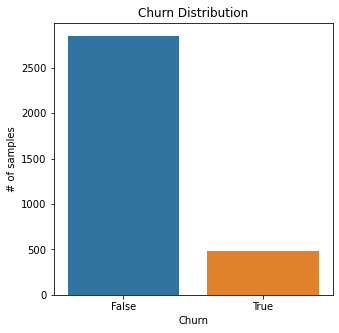

In [24]:
# Checking the distribution of the target variable, 'churn'
churn_distribution = df["churn"].value_counts()

plt.figure(figsize=(5,5))
ax = sns.barplot(x = churn_distribution.index, y = churn_distribution.values)
ax.set(xlabel='Churn', ylabel='# of samples', title = 'Churn Distribution')
plt.show()

In [25]:
# Identifying the majority class
df.churn.value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

At roughly 85.5%, the majority class for our target, 'churn', is False. This means that roughly 85.5% of the samples in this dataset do not represent customer churn. 

In [26]:
# Calculating churn rate
churn_rate = df.churn.value_counts(normalize=True)
print("Churn rate is %.2f%%." % (churn_rate[1] * 100))

Churn rate is 14.49%.


Analysis so far shows the dataset is disproportionate in that it has substanitally more samples of customers without churn than customers with churn. Churn rate of 14.49% implies a class imbalance for the target variable, which could introduce bias into a predicitve model. Oversampling techniques, such as SMOTE, will be introduced later to help account for this imbalance.

# Data Preprocessing

Before building any models, pipelines and column transformers will be used to preprocess and transform the data.

In [27]:
# Label Encode the target variable


In [28]:
# Create mini pipelines for ColumnTransformer: 
# Numeric Pipeline: Standard scaling numerical data
num_pipe = Pipeline([('ss', StandardScaler())])

# Categorical Pipeline: One hot encoding categorical data
cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [29]:
# Instatiating ColumnTransformer

CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include=np.number)),
    ('cat_trans', cat_pipe, selector(dtype_include=object))
],remainder='passthrough')

# Building Dummy Model

In [30]:
# Start by splitting up the data into a training and test set 
# Assign variables to predictors(X) and target(y = 'churn')

X = df.drop('churn', axis = 1)
y = df.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
 class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

CV Results for `dummy` model:
           0.85674 ± 0.00149 accuracy
       


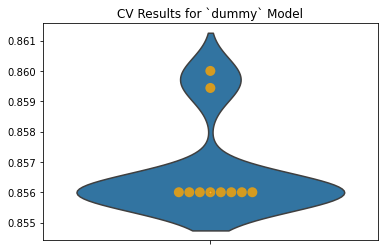

In [32]:
# Create dummy / baseline model

dummy_model = Pipeline([
    ('ct',CT),
    ('dummy',DummyClassifier(strategy='most_frequent'))
])

dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy',X=X_train, y=y_train)

# Visualizing results with violin and swarm plot

fig,ax = plt.subplots()
dummy_model_pipe.plot_cv(ax=ax)

dummy_model_pipe.print_cv_summary()

Violin plot shows a graphic representation of the distribution of the target and the swarm plot shows the dots which represent the results of the cross-validation. Dummy model cross-val score is roughly 85% which is consistent with what we would have guessed by simply looking at the 'churn' distribution and picking the majority class. 

# First Simple Logistic Regression Model

CV Results for `fsm` model:
           0.85915 ± 0.01447 accuracy
       


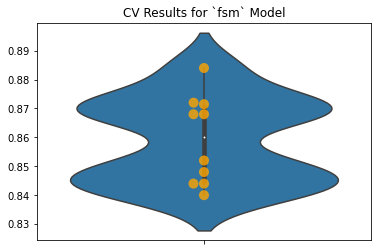

In [33]:
# Create first simple logistic regression model
logreg_fsm = Pipeline([
    ('ct',CT),
    ('logreg_fsm',LogisticRegression(random_state=42))
])

fsm_model_pipe =  ModelWithCV(logreg_fsm, model_name='fsm',X=X_train, y=y_train)

# Visualizing results with violin and swarm plot
fig,ax = plt.subplots()
fsm_model_pipe.plot_cv(ax=ax)

fsm_model_pipe.print_cv_summary()

Not much improvement over the dummy model

In [34]:
# Fit model and get test score
logreg_fsm.fit(X_train, y_train)
logreg_fsm.score(X_test, y_test)

0.8573141486810552

# Decision Tree Classifier Model

CV Results for `dtc_pipe` model:
           0.90957 ± 0.02498 accuracy
       


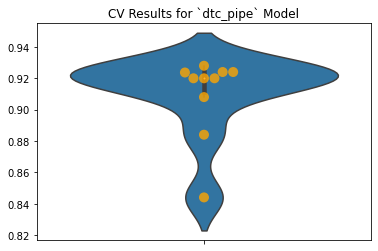

In [35]:
# Create Decision Tree Classifier Model
dtc_model_pipe = Pipeline([('ct', CT), ('dtc', DecisionTreeClassifier(random_state=42))])

dtc_pipe = ModelWithCV(model=dtc_model_pipe,
                          model_name='dtc_pipe',
                          X=X_train,
                          y=y_train)

# Visualizing results with violin and swarm plot

fig, ax = plt.subplots()

dtc_pipe.plot_cv(ax=ax)

dtc_pipe.print_cv_summary()

Decision Tree improves on the first simple logistic regression model

In [36]:
# Fit model and get test score
dtc_model_pipe.fit(X_train, y_train)
dtc_model_pipe.score(X_test, y_test)

0.9256594724220624

Testing score is better than training score

# Random Forest Model

CV Results for `forest_pipe` model:
           0.93838 ± 0.00718 accuracy
       


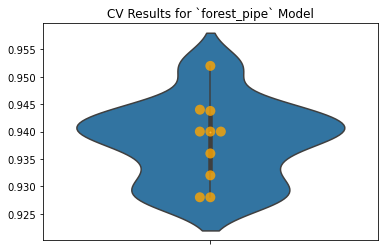

In [37]:
# Create Random Forest Model
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

# Visualizing results with violin and swarm plot
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

forest_pipe.print_cv_summary()

Random forest model has a nice improvement over decision tree model

In [38]:
# Fit model and get test score
rfc_model_pipe.fit(X_train, y_train)
rfc_model_pipe.score(X_test, y_test)

0.9424460431654677

Testing score is better than the training score

# Gradient Booster

CV Results for `gbc_pipe` model:
           0.94918 ± 0.01059 accuracy
       


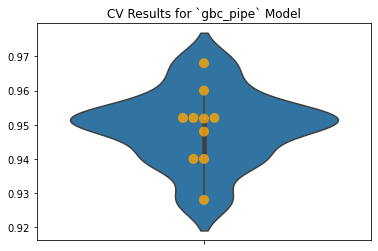

In [39]:
# Create Gradient Boosting Classifier Model
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_pipe = ModelWithCV(model=gbc_model_pipe,
                          model_name='gbc_pipe',
                          X=X_train,
                          y=y_train)

# Visualizing results with violin and swarm plot

fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax=ax)

gbc_pipe.print_cv_summary()

Gradient booster improves over the random forest model

In [40]:
# Fit model and get test score
gbc_model_pipe.fit(X_train, y_train)
gbc_model_pipe.score(X_test, y_test)

0.9496402877697842

Testing score is roughly equal to training score